<a href="https://colab.research.google.com/github/joelvalerian/simple-autoencoder-anomaly-detection/blob/main/Simple_Autoencoder_Anomaly_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Autoencoder Anomaly Detector
---
### Written by Joel Valerian
---
This is an unsupervised deep neural network trained to detect anomalies. The architecture of the neural network is an [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder). This code is use for an undergraduate thesis titled "Detection of Suboptimal IMRT Treatment Plan using Machine Learning on Radiomics Features of Dose Distribution for Lung Cancers" which is part of a [KBRT](https://doi.org/10.1186/s13014-015-0416-6) research in Department of Physics in University of Indonesia. The [radiomics](https://pyradiomics.readthedocs.io/en/latest/) of dose distribution is used as both the input and output of the model. The data extraction process (radiomics calculation and converting DICOM to CSV) is done outside of this code. The raw data is not provided because it's a real medical record that is supposed to be private and for research purpose only. This model is trained on a very limited dataset (34 rows) but can be used for more.

Disclaimer: The result of the undergraduate thesis research is a [null result](https://en.wikipedia.org/wiki/Null_result), most likely due to the limited data set or a dirty input (radiomics features). Nevertheless, the result is still useful for further ML research in KBRT.

In [17]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import csv
import pandas as pd
import time

In [18]:
# System configuration
filepath = '/content/drive/MyDrive/Universitas Indonesia/Akademik/Skripsi/Data/'
random_state = 1
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device used is', device)

Device used is cuda


In [19]:
# Import data
# Options 1 (normal data)
data_numpy = pd.read_csv(filepath + 'data_radiomics_selected.csv').to_numpy().astype(np.float32)
anomali_numpy = pd.read_csv(filepath + 'anomali_radiomics_selected.csv').to_numpy().astype(np.float32)

# Options 2 (refined data)
# data_numpy = pd.read_csv(filepath + 'data_radiomics_selected.csv', skiprows=[13, 23, 31]).to_numpy().astype(np.float32)
# anomali_numpy = pd.read_csv(filepath + 'anomali_radiomics_selected.csv', skiprows=[1, 5, 6, 8]).to_numpy().astype(np.float32)

# Options 3 (filtered data)
# columnname = ['10Percentile_PTV', '10Percentile_PTV', '90Percentile_LungL', '90Percentile_PTV', 'InterquartileRange_PTV', 'Kurtosis_LungR', 'Maximum_Body', 'Maximum_LungL', 'Maximum_PTV', 'MeanAbsoluteDeviation_PTV', 'Mean_PTV', 'Median_PTV', 'Range_Body', 'Range_LungL', 'Range_PTV', 'RobustMeanAbsoluteDeviation_PTV', 'RootMeanSquared_PTV', 'Skewness_Heart', 'Variance_PTV', 'GrayLevelNonUniformity_Heart']
# data_numpy = pd.read_csv(filepath + 'data_radiomics_selected.csv', usecols=columnname).to_numpy().astype(np.float32)
# anomali_numpy = pd.read_csv(filepath + 'anomali_radiomics_selected.csv', usecols=columnname).to_numpy().astype(np.float32)

In [20]:
# Scale data
data_scaler = StandardScaler()
data_numpy = data_scaler.fit_transform(data_numpy)
anomali_numpy = data_scaler.fit_transform(anomali_numpy)

In [21]:
# Split data
# Options 1 (normal splitting)
training_data_numpy, testing_data_numpy = train_test_split(data_numpy, test_size=0.1, random_state=random_state)

# Options 2 (splitting for non-normal data)
# a =  [3, 13, 18, 25]
# b = [i for i in np.arange(0, 31, 1) if i not in a]
# training_data_numpy = data_numpy[b]
# testing_data_numpy = data_numpy[a]

In [22]:
# Prepare data (convert to PyTorch tensor)
training_data = torch.from_numpy(training_data_numpy).to(device)
testing_data = torch.from_numpy(testing_data_numpy).to(device)
data = torch.from_numpy(data_numpy).to(device)
anomali = torch.from_numpy(anomali_numpy).to(device)

In [23]:
# Data information
# Extract data shape
training_data_n_samples, training_data_n_features = training_data.shape
testing_data_n_samples, testing_data_n_features = testing_data.shape
data_n_samples, data_n_features = data.shape
anomali_n_samples, anomali_n_features = anomali.shape

In [24]:
# Check data shape
print(training_data.shape)
print(testing_data.shape)
print(data.shape)
print(anomali.shape)

torch.Size([30, 161])
torch.Size([4, 161])
torch.Size([34, 161])
torch.Size([10, 161])


In [25]:
# Define hyperparameter
learning_rate = 0.2
num_epochs = 1250
hl_1 = 150
hl_2 = 50
hl_3 = 17
input_size = data_n_features
output_size = data_n_features

In [26]:
# Define model specification
class Autoencoder(nn.Module):
  def __init__(self, input_dim, output_dim, hl_1, hl_2, hl_3):
    super(Autoencoder, self).__init__()
    self.fc1 = nn.Linear(input_dim, hl_1)
    self.fc2 = nn.Linear(hl_1, hl_2)
    self.fc3 = nn.Linear(hl_2, hl_3)
    self.fc4 = nn.Linear(hl_3, hl_2)
    self.fc5 = nn.Linear(hl_2, hl_1)
    self.fc6 = nn.Linear(hl_1, output_dim)
  
  def encode(self, x):
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))
    x = torch.tanh(self.fc3(x))
    return x

  def decode(self, x):
    x = torch.tanh(self.fc4(x))
    x = torch.tanh(self.fc5(x))
    x = self.fc6(x)
    return x

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x

In [27]:
# Load model
model = Autoencoder(input_size, output_size, hl_1, hl_2, hl_3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [28]:
# Train model
start = time.process_time() 

loss_list = []  # Reconstruction error of training data (data used in training)
err_list = []   # Reconstruction error of testing data (data used in testing)
miss_list = []  # Reconstruction error of anomaly data (data that is supposed to be detected as anomaly)

for epoch in range(num_epochs+1):
  # Reset gradients
  optimizer.zero_grad()
  
  # Forward pass
  data_pred = model(training_data)

  # Calculate loss
  loss = criterion(data_pred, training_data)

  # Backward pass
  loss.backward()

  # Update weights
  optimizer.step()

  # Check accuracies
  result = []
  with torch.no_grad():
    test_pred = model(testing_data)
    err = criterion(test_pred, testing_data)
    anom_pred = model(anomali)
    miss = criterion(anom_pred, anomali)
  loss_list.append(loss.item())
  err_list.append(err.item())
  miss_list.append(miss.item())

  # Print training epochs
  if epoch % int(num_epochs/10) == 0:
    print(f'Epoch {epoch} -> loss = {loss:.6f} error = {err:.6f} miss = {miss:.6f}')

end = time.process_time()
print(f'{end-start:.2f} second(s)')

Epoch 0 -> loss = 1.023228 error = 0.905110 miss = 1.008615
Epoch 125 -> loss = 0.648428 error = 0.571982 miss = 0.670674
Epoch 250 -> loss = 0.426683 error = 0.462958 miss = 0.505099
Epoch 375 -> loss = 0.347715 error = 0.472961 miss = 0.479665
Epoch 500 -> loss = 0.289747 error = 0.477245 miss = 0.453988
Epoch 625 -> loss = 0.256509 error = 0.488333 miss = 0.441441
Epoch 750 -> loss = 0.226574 error = 0.501229 miss = 0.411050
Epoch 875 -> loss = 0.194725 error = 0.489598 miss = 0.387832
Epoch 1000 -> loss = 0.169538 error = 0.476831 miss = 0.380088
Epoch 1125 -> loss = 0.146315 error = 0.458174 miss = 0.375645
Epoch 1250 -> loss = 0.124916 error = 0.446518 miss = 0.368911
4.03 second(s)


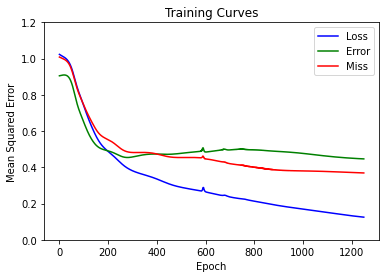

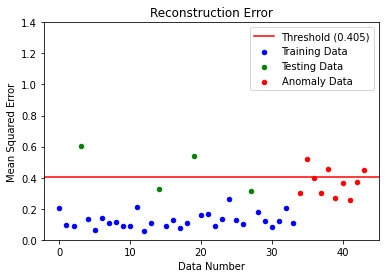

In [29]:
# Plot loss, error, and miss
fig1, ax1 = plt.subplots()
ax1.set_title('Training Curves')
ax1.plot(loss_list, 'b', label='Loss')
ax1.plot(err_list, 'g', label='Error')
ax1.plot(miss_list, 'r', label='Miss')
# ax1.set_yscale('log') # Optional
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.legend()
#ax1.set_xlim(0, 5000) # Optional
ax1.set_ylim(0, 1.2) # Optional
fig1.savefig('kurva latihan.png', dpi=1200)
plt.show(fig1)
plt.close(fig1)

# Reconstruction error for each data point
data_err = []
with torch.no_grad():
  pred_data = model(data)
  for i in range(len(data)):
    error = criterion(pred_data[i], data[i])
    data_err.append(error.item())

anom_err = []
with torch.no_grad():
  pred_anom = model(anomali)
  for i in range(len(anomali)):
    error = criterion(pred_anom[i], anomali[i])
    anom_err.append(error.item())

# Plot reconstruction error
fig2, ax2 = plt.subplots()

# Create index for each data for coloring
train_index = np.arange(0, data_n_samples, 1)
test_index = []
for n in range(len(testing_data_numpy[:,2])):
  index = np.where(data_numpy[:,2] == testing_data_numpy[:,2][n])
  test_index.append(index[0].item())
train_index = [x for x in train_index if x not in test_index]
anom_index = np.arange(data_n_samples, data_n_samples+anomali_n_samples, 1)
train_err = [data_err[i] for i in train_index]
test_err = [data_err[i] for i in test_index]

# Create scatter plot
ax2.scatter(train_index, train_err, c='blue', s=20, label='Training Data')
ax2.scatter(test_index, test_err, c='green', s=20, label='Testing Data')
ax2.scatter(anom_index, anom_err, c='red', s=20, label='Anomaly Data')
mean = np.mean(data_err) #alternative without testing data: [data_err[i] for i in train_index]
threshold = mean + 2*np.std(data_err) # Threshold is arbitrary but two standard deviation is considered good
ax2.set_title('Reconstruction Error')
ax2.axhline(threshold, color='r', label=f'Threshold ({threshold:.3f})')
ax2.set_xlabel('Data Number')
ax2.set_ylabel('Mean Squared Error')
ax2.legend()
ax2.set_ylim(0, 1.4)
fig2.savefig('eror rekonstruksi.png', dpi=1200)
plt.show(fig2)
plt.close(fig2)

In [30]:
# Print testing data index
print('Index data uji', test_index)

Index data uji [14, 19, 3, 27]


In [31]:
# Check for training data above threshold
outlier = []
for i in range(len(data_err)):
  if data_err[i] > threshold and i not in test_index:
      outlier.append(i)
      print(f'No. {i}, Error: {data_err[i]}')
if len(outlier) == 0:
  print("No anomalies detected!")

No anomalies detected!


In [32]:
# Check for anomaly data above threshold
print('Anomaly data above threshold', [index for index in range(len(anom_err)) if anom_err[index] > threshold])

Anomaly data above threshold [1, 4, 9]
